# Brain Tumor Classification

In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:
# Import data managing libraries
import numpy as np
import pandas as pd

# Import Tensorflow
import tensorflow as tf
import tensorflow.keras as keras

# Plotting
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import random
# Set the seed for repeatability
seed = 42

# Set random seed for NumPy
np.random.seed(42)

# Set random seed for TensorFlow
tf.random.set_seed(42)

# Set random seed for Python's built-in random module
random.seed(42)

In [3]:
from functions import process_data
import os

# Define data folder
data_folder = "data/"

# Define train, val, test folders
train_folder = os.path.join(data_folder, "Training/")
test_folder = os.path.join(data_folder, "Testing/")
val_folder = os.path.join(data_folder, "Validation/")

# Define our data directories
train_data_dir = train_folder
test_data_dir = test_folder
val_data_dir = val_folder

train_gen, test_gen, val_gen = process_data(128, 32, train_data_dir, test_data_dir, val_data_dir)

Found 2297 images belonging to 4 classes.
Found 394 images belonging to 4 classes.
Found 573 images belonging to 4 classes.


In [4]:
# Find out how the image data generators labeled our classes
train_class_labels = train_gen.class_indices
val_class_labels = train_gen.class_indices
test_class_labels = val_gen.class_indices

# Print the class labels
print("Train Class Labels:", train_class_labels)
print("Validation Class Labels:", val_class_labels)
print("Test Class Labels:", test_class_labels)

Train Class Labels: {'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}
Validation Class Labels: {'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}
Test Class Labels: {'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}


In [5]:
# Retrieve one batch of data from the generator
data_batch, label_batch = next(train_gen)

# Print the shape of the data batch and label batch
print("Data batch shape:", data_batch.shape)
print("Label batch shape:", label_batch.shape)

Data batch shape: (32, 128, 128, 3)
Label batch shape: (32, 4)


Image dimensions: (128, 128, 3)


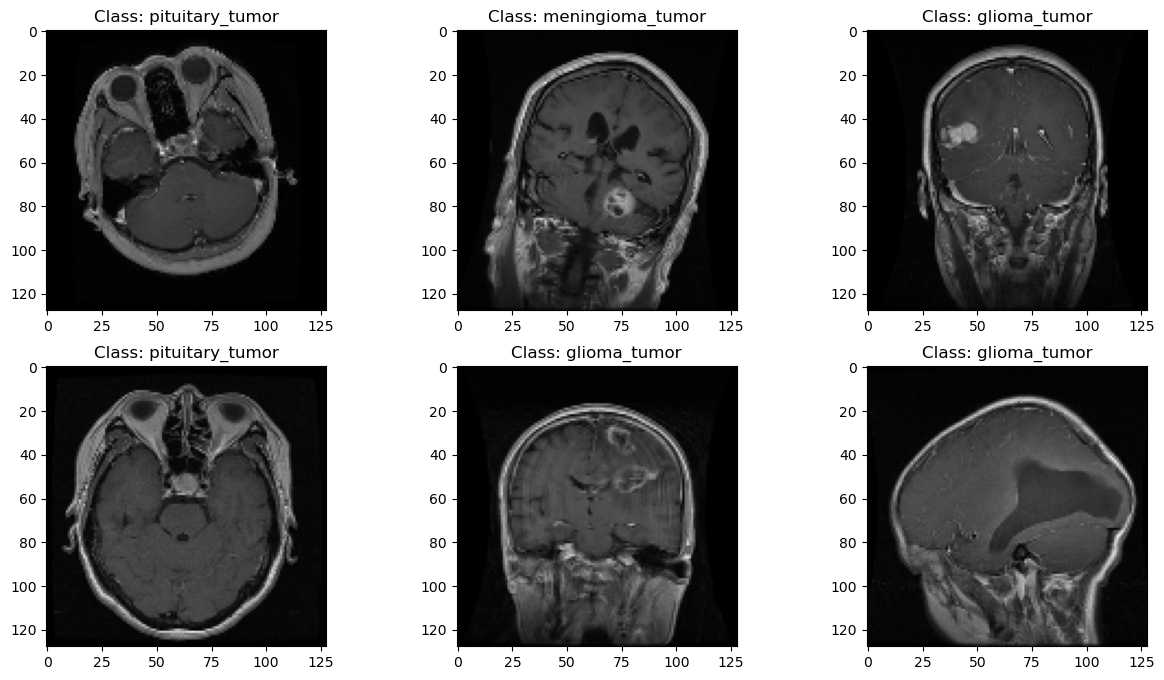

In [6]:
import matplotlib.pyplot as plt

# Retrieve one batch of images from the generator
images, labels = train_gen.next()

# Print the dimensions of the first image
print("Image dimensions:", images[0].shape)

# Define the class labels
class_labels = {'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}

# Display the first six images with their labels
fig, ax = plt.subplots(2, 3, facecolor='white', figsize=(15, 8))

for i in range(2):
    for j in range(3):
        # Calculate the index in the images and labels arrays
        idx = i * 3 + j
        
        # Get the predicted class
        class_idx = np.argmax(labels[idx])
        
        # Get the class name from the label
        class_name = [key for key, value in class_labels.items() if value == class_idx][0]
        
        # Plot the image
        ax[i, j].imshow(images[idx])
        ax[i, j].set_title(f"Class: {class_name}")

plt.show()

We want to implement cross-validation into the training process. There are no built in methods within keras that can allow for this to happen but there are methods in scikit-learn. We can take the generators that pre-priocess the data and append the images to a dataframe. From there we can then split the data using KFold. 

In [ ]:
# # Extract data and labels from the generated batches on train set
# data_train, labels_train = [], []
# for _ in range(len(train_gen)):
#     images_train, batch_labels_train = train_gen.next()  # Get the next batch of data
#     data_train.extend(images_train)
#     labels_train.extend(batch_labels_train)

# # Extract data and labels from the generated batches on test set
# data_test, labels_test = [], []
# for _ in range(len(test_gen)):
#     images_test, batch_labels_test = test_gen.next()  # Get the next batch of data
#     data_test.extend(images_train)
#     labels_test.extend(batch_labels_test)

# # Extract data and labels from the generated batches on validation set
# data_val, labels_val = [], []
# for _ in range(len(val_gen)):
#     images_val, batch_labels_val = val_gen.next()  # Get the next batch of data
#     data_val.extend(images_val)
#     labels_val.extend(batch_labels_val)

# # Flatten the image data
# data_train_flat = np.array(data_train).reshape(len(data_train), -1)
# data_test_flat = np.array(data_test).reshape(len(data_test), -1)
# data_val_flat = np.array(data_val).reshape(len(data_val), -1)

# # Create Dataframes for each set. Keep class labels in order
# df_train_data = pd.DataFrame(data_train_flat)
# df_train_labels = pd.DataFrame(labels_train, columns=["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"])
# df_train = pd.concat([df_train_data, df_train_labels], axis=1)

# df_test_data = pd.DataFrame(data_test_flat)
# df_test_labels = pd.DataFrame(labels_test, columns=["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"])
# df_test = pd.concat([df_test_data, df_test_labels], axis=1)

# df_val_data = pd.DataFrame(data_val_flat)
# df_val_labels = pd.DataFrame(labels_val, columns=["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"])
# df_val = pd.concat([df_val_data, df_val_labels], axis=1)

In [ ]:
# df_train.head(5)

In [ ]:
# # Display the shape of each DataFrame
# print("Train DataFrame shape:", df_train.shape)
# print("Test DataFrame shape:", df_test.shape)
# print("Validation DataFrame shape:", df_val.shape)

Seems that the dataframe worked. We have almost 20,000 columns for image data and the last four columns are our labels. 

# Convolutinal Base

In [11]:
from tensorflow.keras.metrics import Precision, Recall

# Define metrics we want to log for the compile method callback
metrics = [
        Precision(name='precision'),
        Recall(name='recall'),
        'accuracy'
    ]


In [12]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Conv2D, MaxPool2D
from keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy

# Define input shape
input_shape = (128, 128, 3)

# Define the basic model 
cnn = Sequential()

# Define the layers 
# Flatten layer to reshape the output
cnn.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu', strides=(1,1), padding='same', input_shape=input_shape))
cnn.add(MaxPool2D(pool_size=(2,2)))

# Flatten Tensor
cnn.add(Flatten())
cnn.add(Dense(128, activation='relu'))

# Define the output 
cnn.add(Dense(4, activation='softmax'))

cnn.compile(optimizer=Adam(), loss=CategoricalCrossentropy(), metrics=metrics)
print(cnn.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 64, 64, 16)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 65536)             0         
                                                                 
 dense_2 (Dense)             (None, 128)               8388736   
                                                                 
 dense_3 (Dense)             (None, 4)                 516       
                                                                 
Total params: 8,389,700
Trainable params: 8,389,700
Non-trainable params: 0
____________________________________________

Epoch 1/100
72/72 [==============================] - 4s 42ms/step - loss: 1.5881 - precision: 0.6018 - recall: 0.4388 - accuracy: 0.5629 - val_loss: 0.7335 - val_precision: 0.7529 - val_recall: 0.5742 - val_accuracy: 0.7051 - lr: 0.0010
Epoch 2/100
72/72 [==============================] - 3s 39ms/step - loss: 0.5954 - precision: 0.8085 - recall: 0.7022 - accuracy: 0.7754 - val_loss: 0.6202 - val_precision: 0.7610 - val_recall: 0.6946 - val_accuracy: 0.7504 - lr: 0.0010
Epoch 3/100
72/72 [==============================] - 3s 40ms/step - loss: 0.4247 - precision: 0.8570 - recall: 0.7984 - accuracy: 0.8341 - val_loss: 0.7332 - val_precision: 0.6993 - val_recall: 0.6736 - val_accuracy: 0.6876 - lr: 0.0010
Epoch 4/100
72/72 [==============================] - 3s 40ms/step - loss: 0.2946 - precision: 0.9043 - recall: 0.8798 - accuracy: 0.8938 - val_loss: 0.5224 - val_precision: 0.8248 - val_recall: 0.7888 - val_accuracy: 0.8045 - lr: 0.0010
Epoch 5/100
72/72 [==============================] -

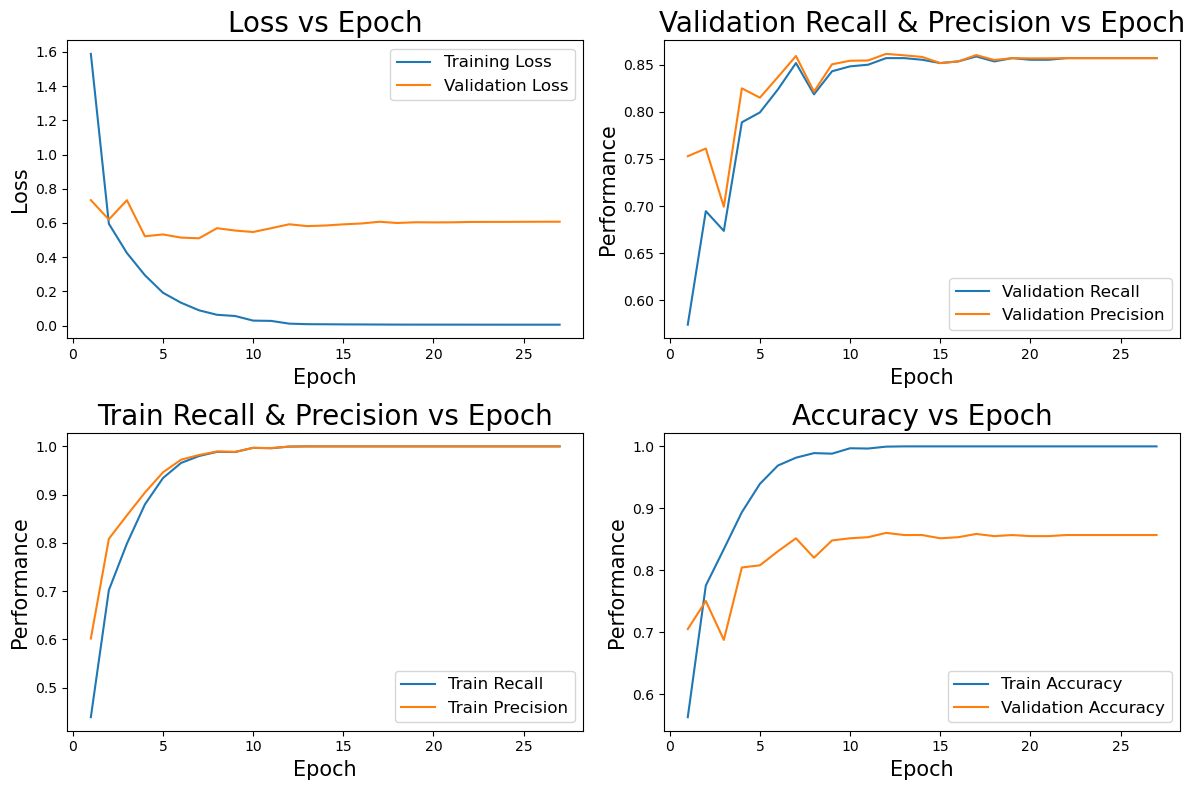

 3/13 [=====>........................] - ETA: 0s - loss: 8.9149 - precision: 0.2151 - recall: 0.2083 - accuracy: 0.2188 

c:\Users\delga\Documents\Phase5\brain_tumor_classification\functions.py:312: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame([dict(zip(columns, train_metrics))])], ignore_index=True)


18/18 [==============================] - 1s 31ms/step - loss: 0.5106 - precision: 0.8592 - recall: 0.8517 - accuracy: 0.8517


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.060683,99.216372,99.216372,99.216372
1,Test,2.868017,67.958659,66.751271,67.005074
2,Validation,0.510639,85.915494,85.165793,85.165793


In [13]:
from functions import train_model, model_evaluate, view_history

conv = {}

# Train model
conv['Version1'] = train_model(cnn, train_gen, val_gen, 100)

# View history 
view_history(conv, 'Version1')

# Evalaute model
model_evaluate(cnn, train_gen, test_gen, val_gen)

It seems that our might be overfitting or another possibility is that we arent capturing enought of the data complexity. We plateau pretty often for val_loss and the train_loss is getting closer to zero. 

**Next Steps**: Increase model complexity to confirm overfit.

# CNN Version 2

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy

# Define input shape
input_shape = (128, 128, 3)

# Define the basic model 
cnn2 = Sequential()

# Define the layers 
# Flatten layer to reshape the output
cnn2.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', strides=(1,1), padding='same', input_shape=input_shape))
cnn2.add(MaxPool2D(pool_size=(2,2)))

# Flatten Tensor
cnn2.add(Flatten())
cnn2.add(Dense(256, activation='relu'))
cnn2.add(Dense(256, activation='relu'))

# Define the output 
cnn2.add(Dense(4, activation='softmax'))

cnn2.compile(optimizer=Adam(), loss=CategoricalCrossentropy(), metrics=metrics)
print(cnn2.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 262144)            0         
                                                                 
 dense_7 (Dense)             (None, 256)               67109120  
                                                                 
 dense_8 (Dense)             (None, 256)               65792     
                                                                 
 dense_9 (Dense)             (None, 4)                 1028      
                                                      

Epoch 1/100
72/72 [==============================] - 4s 44ms/step - loss: 1.0449 - precision: 0.7312 - recall: 0.5801 - accuracy: 0.6282 - val_loss: 0.5359 - val_precision: 0.7982 - val_recall: 0.7661 - val_accuracy: 0.7818 - lr: 0.0010
Epoch 2/100
72/72 [==============================] - 3s 43ms/step - loss: 0.3043 - precision: 0.8898 - recall: 0.8681 - accuracy: 0.8798 - val_loss: 0.4983 - val_precision: 0.8212 - val_recall: 0.7853 - val_accuracy: 0.8063 - lr: 0.0010
Epoch 3/100
72/72 [==============================] - 3s 42ms/step - loss: 0.0870 - precision: 0.9742 - recall: 0.9700 - accuracy: 0.9730 - val_loss: 0.4014 - val_precision: 0.8680 - val_recall: 0.8604 - val_accuracy: 0.8621 - lr: 0.0010
Epoch 4/100
72/72 [==============================] - 3s 42ms/step - loss: 0.0265 - precision: 0.9926 - recall: 0.9922 - accuracy: 0.9922 - val_loss: 0.4406 - val_precision: 0.8717 - val_recall: 0.8656 - val_accuracy: 0.8656 - lr: 0.0010
Epoch 5/100
72/72 [==============================] -

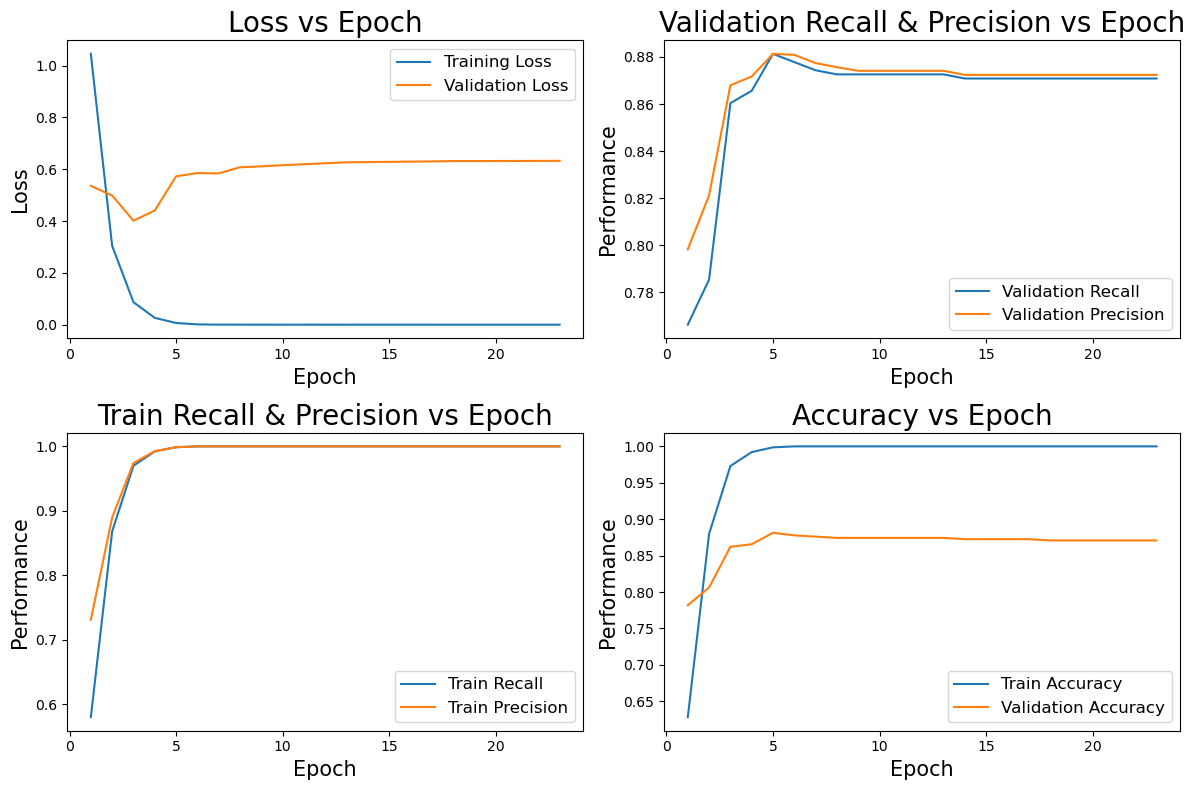

 3/13 [=====>........................] - ETA: 0s - loss: 7.6677 - precision: 0.1957 - recall: 0.1875 - accuracy: 0.1875            

c:\Users\delga\Documents\Phase5\brain_tumor_classification\functions.py:312: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame([dict(zip(columns, train_metrics))])], ignore_index=True)


18/18 [==============================] - 1s 31ms/step - loss: 0.4014 - precision: 0.8680 - recall: 0.8604 - accuracy: 0.8621


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.028721,99.564272,99.477577,99.477577
1,Test,2.470592,66.842103,64.467007,65.989846
2,Validation,0.401382,86.795777,86.038393,86.212915


In [17]:
from functions import train_model, model_evaluate, view_history

# Train model
conv['Version2'] = train_model(cnn2, train_gen, val_gen, 100)

# View history 
view_history(conv, 'Version2')

# Evalaute model
model_evaluate(cnn2, train_gen, test_gen, val_gen)

Increasing the complexity of the Convolutional layer caused us to overfit. This is also true for increasing neurons.

Next Steps: keep the same complexity as our train curve is better but introduce regularization

# CNN Version 3

Lets implement a model framework from a [publication](https://ieeexplore.ieee.org/document/8723045).

In [19]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Conv2D, MaxPool2D, Dropout
from keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy

# Define input shape
input_shape = (128, 128, 3)

# Define the basic model 
cnn3 = Sequential()

# Define the layers 
# Flatten layer to reshape the output
cnn3.add(Conv2D(filters=64, kernel_size=(10, 10), strides=(1,1), activation='relu', padding='same', input_shape=input_shape))
cnn3.add(MaxPool2D(pool_size=(2,2)))
cnn3.add(Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
cnn3.add(MaxPool2D(pool_size=(2,2)))
cnn3.add(Dropout(.2))
cnn3.add(Conv2D(filters=128, kernel_size=(2,2), strides=(1,1), padding='same', activation='relu'))
cnn3.add(MaxPool2D(pool_size=(2,2)))
cnn3.add(Dropout(.2))

# Flatten Tensor and create Fully conected layer
cnn3.add(Flatten())
cnn3.add(Dense(256, activation='relu'))

# Define the output layer 
cnn3.add(Dense(4, activation='softmax'))

cnn3.compile(optimizer=Adam(), loss=CategoricalCrossentropy(), metrics=metrics)
print(cnn3.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 128, 128, 64)      19264     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 64, 64, 128)       73856     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 32, 32, 128)      0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 32, 32, 128)       0         
                                                                 
 conv2d_11 (Conv2D)          (None, 32, 32, 128)      

Epoch 1/100
72/72 [==============================] - 4s 43ms/step - loss: 1.2084 - precision: 0.6997 - recall: 0.3345 - accuracy: 0.4680 - val_loss: 0.9286 - val_precision: 0.6424 - val_recall: 0.3857 - val_accuracy: 0.5812 - lr: 0.0010
Epoch 2/100
72/72 [==============================] - 3s 39ms/step - loss: 0.7895 - precision: 0.7131 - recall: 0.5768 - accuracy: 0.6617 - val_loss: 0.8596 - val_precision: 0.6713 - val_recall: 0.5881 - val_accuracy: 0.6405 - lr: 0.0010
Epoch 3/100
72/72 [==============================] - 3s 40ms/step - loss: 0.5950 - precision: 0.7772 - recall: 0.7079 - accuracy: 0.7510 - val_loss: 0.5754 - val_precision: 0.7981 - val_recall: 0.7173 - val_accuracy: 0.7539 - lr: 0.0010
Epoch 4/100
72/72 [==============================] - 3s 39ms/step - loss: 0.4296 - precision: 0.8494 - recall: 0.8128 - accuracy: 0.8333 - val_loss: 0.5889 - val_precision: 0.7646 - val_recall: 0.7086 - val_accuracy: 0.7400 - lr: 0.0010
Epoch 5/100
72/72 [==============================] -

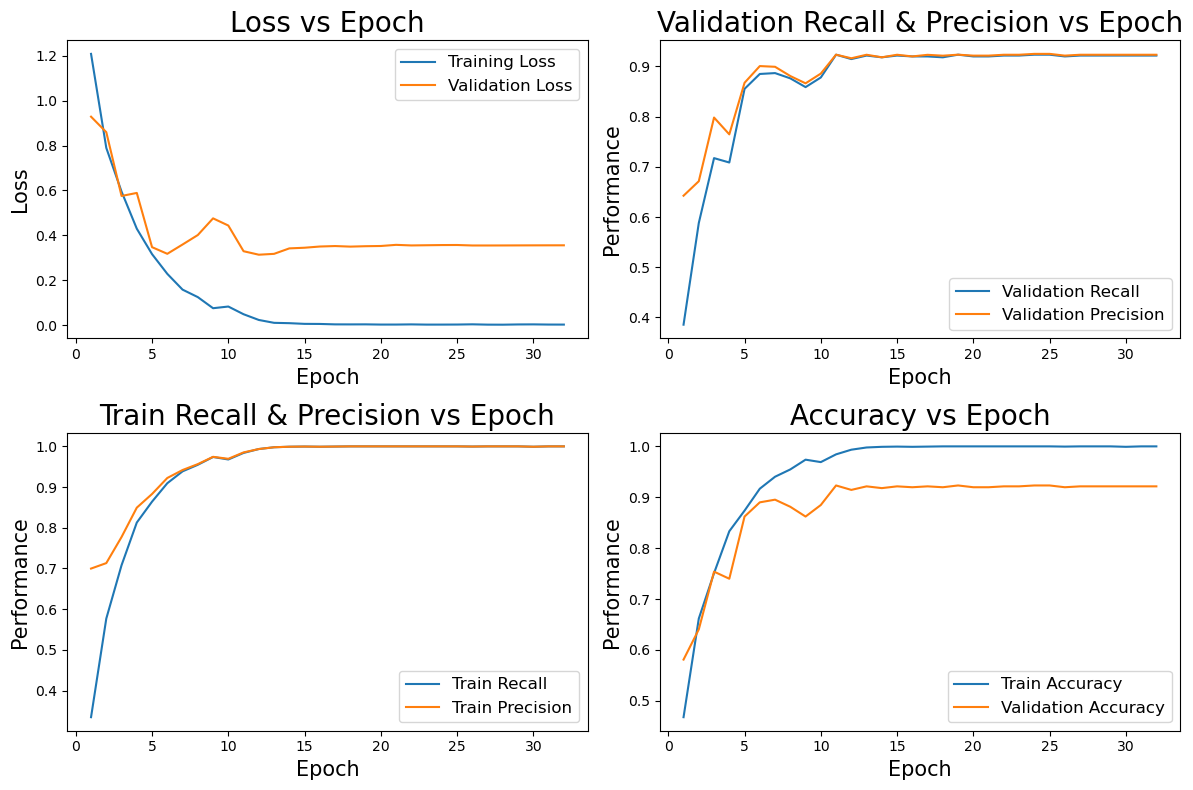

 3/13 [=====>........................] - ETA: 0s - loss: 21.0638 - precision: 0.1875 - recall: 0.1875 - accuracy: 0.1875            

c:\Users\delga\Documents\Phase5\brain_tumor_classification\functions.py:312: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame([dict(zip(columns, train_metrics))])], ignore_index=True)


18/18 [==============================] - 1s 32ms/step - loss: 0.3137 - precision: 0.9161 - recall: 0.9145 - accuracy: 0.9145


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.008911,99.825859,99.825859,99.825859
1,Test,6.022875,67.512691,67.512691,67.512691
2,Validation,0.313725,91.608393,91.448516,91.448516


In [20]:
from functions import train_model, view_history, model_evaluate

# Train model
conv['Version3'] = train_model(cnn3, train_gen, val_gen, 100)

# View history 
view_history(conv, 'Version3')

# Evalaute model
model_evaluate(cnn3, train_gen, test_gen, val_gen)

This framework seemed to work very well. We just need to fine tune the model by doing a hyperparam search.

# Hyperparm Tuning